In [1]:
#basic imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 8,4
import warnings
warnings.filterwarnings('ignore')

#import statiscial models api
import statsmodels.api as sm

In [2]:
# Simple One Factor Linear Regression

mba_df = pd.read_csv('MBA Salary.csv')

In [3]:
mba_df.head()

,S. No.,Percentage in Grade 10,Salary
0,1,62.00,270000
1,2,76.33,200000
2,3,72.00,240000
3,4,60.00,250000
4,5,61.00,180000


In [4]:
#Lets add a 1.0 constant term to the salary dataset so we can estimate intercept value of linear reg. equation
X = sm.add_constant(mba_df["Percentage in Grade 10"])
X.head()

,const,Percentage in Grade 10
0,1.0,62.00
1,1.0,76.33
2,1.0,72.00
3,1.0,60.00
4,1.0,61.00


In [5]:
Y = mba_df['Salary']
Y.head()

0    270000
1    200000
2    240000
3    250000
4    180000
Name: Salary, dtype: int64

In [6]:
# Lets split the data
from sklearn.model_selection import train_test_split

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=0.8, random_state=100)

In [8]:
#Now, lets fit the model

mba_salary_lm = sm.OLS(train_Y, train_X).fit()


In [9]:
print(mba_salary_lm.params)

const                     30587.285652
Percentage in Grade 10     3560.587383
dtype: float64


<Figure size 576x432 with 0 Axes>

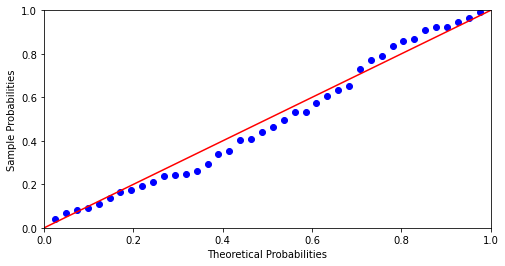

In [10]:
# Now, lets diagnose the model
mba_df_resid = mba_salary_lm.resid

probplot = sm.ProbPlot(mba_df_resid, fit=True)

plt.figure(figsize=(8, 6))
probplot.ppplot(line='45')
plt.show()

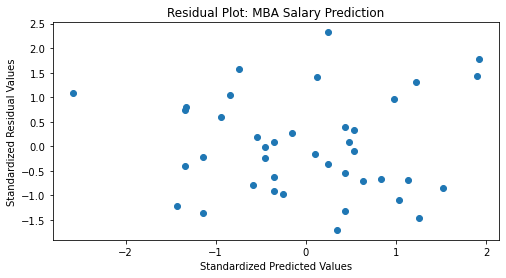

In [73]:
#WE can conclude the CDF of residuals is pretty close to CDF of normal dist. SO assumption is valid
#Now, lets check for homoscedasticity

#first, lets create a func for standardized values
def get_standardized_values(vals):
    return (vals-vals.mean())/(vals.std())

#Now lets plot stand. values of residuals vs stand. values of fitted values
def plot_resid_fitted(fitted, resid, title): 
    plt.scatter(get_standardized_values(fitted), get_standardized_values(resid))
    plt.title(title)
    plt.xlabel('Standardized Predicted Values')
    plt.ylabel('Standardized Residual Values')
    
plot_resid_fitted(mba_salary_lm.fittedvalues, mba_df_resid, "Residual Plot: MBA Salary Prediction")

In [12]:
#Since above plot is random and not in a funnel shape, we can conclude residual variance is constant and hence homoscedasticity is maintained


In [13]:
#Outlier Analysis

#1 Z-Score
from scipy.stats import zscore
mba_df['zscore_salary'] = zscore(mba_df.Salary)

#Z score of more than 3 is considered outlier
mba_df[(mba_df.zscore_salary > 3.0) | (mba_df.zscore_salary < -3.0)]

,S. No.,Percentage in Grade 10,Salary,zscore_salary


In [14]:
# No values of more than 3 so no outliers
#Look at Cooks Distance from book

In [15]:
#Now lets predict values

pred_Y = mba_salary_lm.predict(test_X)

In [16]:
#Now lets find error in pred
#Findinf Root Mean Squared Error RMSE

from sklearn.metrics import r2_score, mean_squared_error
np.abs(r2_score(test_Y, pred_Y))

0.156645849742304

In [17]:
# Lets calc the root mean square error
np.sqrt(mean_squared_error(test_Y, pred_Y))

73458.04348346895

In [18]:
# Lets instead calculate prediction intervals with confidence levels -
from statsmodels.sandbox.regression.predstd import wls_prediction_std

err, pred_Y_low, pred_Y_high = wls_prediction_std(mba_salary_lm, exog=test_X, alpha=0.1)

#Store values in dataframe

pred_Y_df = pd.DataFrame({'grade_10_perc': test_X['Percentage in Grade 10'], 'pred_Y':pred_Y, 'pred_Y_left':pred_Y_low,\
                          'pred_Y_right':pred_Y_high})
pred_Y_df.head()

,grade_10_perc,pred_Y,pred_Y_left,pred_Y_right
6,70.0,279828.402452,158379.832044,401276.972860
36,68.0,272707.227686,151576.715020,393837.740352
37,52.0,215737.829560,92950.942395,338524.716726
28,58.0,237101.353858,115806.869618,358395.838097
43,74.5,295851.045675,173266.083342,418436.008008


In [19]:
err

array([72035.49885795, 71846.84741458, 72829.30248119, 71944.10482994,
       72709.53362778, 71741.81781609, 72310.46293586, 73467.60789736,
       71678.26566477, 72690.84742484])

In [20]:
#Multiple Linear Regression


ipl_df = pd.read_csv('IPL IMB381IPL2013.csv')
ipl_df.head()

,Sl.NO.,PLAYER NAME,AGE,COUNTRY,TEAM,PLAYING ROLE,T-RUNS,T-WKTS,ODI-RUNS-S,ODI-SR-B,...,SR-B,SIXERS,RUNS-C,WKTS,AVE-BL,ECON,SR-BL,AUCTION YEAR,BASE PRICE,SOLD PRICE
0,1,"Abdulla, YA",2,SA,KXIP,Allrounder,0,0,0,0.00,...,0.00,0,307,15,20.47,8.90,13.93,2009,50000,50000
1,2,Abdur Razzak,2,BAN,RCB,Bowler,214,18,657,71.41,...,0.00,0,29,0,0.00,14.50,0.00,2008,50000,50000
2,3,"Agarkar, AB",2,IND,KKR,Bowler,571,58,1269,80.62,...,121.01,5,1059,29,36.52,8.81,24.90,2008,200000,350000
3,4,"Ashwin, R",1,IND,CSK,Bowler,284,31,241,84.56,...,76.32,0,1125,49,22.96,6.23,22.14,2011,100000,850000
4,5,"Badrinath, S",2,IND,CSK,Batsman,63,0,79,45.93,...,120.71,28,0,0,0.00,0.00,0.00,2011,100000,800000


In [22]:
ipl_df.iloc[0:5, 0:10]

,Sl.NO.,PLAYER NAME,AGE,COUNTRY,TEAM,PLAYING ROLE,T-RUNS,T-WKTS,ODI-RUNS-S,ODI-SR-B
0,1,"Abdulla, YA",2,SA,KXIP,Allrounder,0,0,0,0.00
1,2,Abdur Razzak,2,BAN,RCB,Bowler,214,18,657,71.41
2,3,"Agarkar, AB",2,IND,KKR,Bowler,571,58,1269,80.62
3,4,"Ashwin, R",1,IND,CSK,Bowler,284,31,241,84.56
4,5,"Badrinath, S",2,IND,CSK,Batsman,63,0,79,45.93


In [23]:
ipl_df.columns

Index(['Sl.NO.', 'PLAYER NAME', 'AGE', 'COUNTRY', 'TEAM', 'PLAYING ROLE',
       'T-RUNS', 'T-WKTS', 'ODI-RUNS-S', 'ODI-SR-B', 'ODI-WKTS', 'ODI-SR-BL',
       'CAPTAINCY EXP', 'RUNS-S', 'HS', 'AVE', 'SR-B', 'SIXERS', 'RUNS-C',
       'WKTS', 'AVE-BL', 'ECON', 'SR-BL', 'AUCTION YEAR', 'BASE PRICE',
       'SOLD PRICE'],
      dtype='object')

In [45]:
#Lets create an array to store all features that we want to consider
X_features = ['AGE', 'COUNTRY', 'PLAYING ROLE',
       'T-RUNS', 'T-WKTS', 'ODI-RUNS-S', 'ODI-SR-B', 'ODI-WKTS', 'ODI-SR-BL',
       'CAPTAINCY EXP', 'RUNS-S', 'HS', 'AVE', 'SR-B', 'SIXERS', 'RUNS-C',
       'WKTS', 'AVE-BL', 'ECON', 'SR-BL']

#Lets encode one categorical variable to understand and then encode remaining
ipl_df['PLAYING ROLE'].unique()

array(['Allrounder', 'Bowler', 'Batsman', 'W. Keeper'], dtype=object)

In [46]:
pd.get_dummies(ipl_df['PLAYING ROLE'])[0:5]

,Allrounder,Batsman,Bowler,W. Keeper
0,1,0,0,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,1,0,0


In [47]:
#We must create dummy variables for al categorical variables -
categorical_varaibles = ['AGE', 'COUNTRY', 'PLAYING ROLE', 'CAPTAINCY EXP']

ipl_df_encoded = pd.get_dummies(ipl_df[X_features], columns=categorical_varaibles, drop_first=True)
ipl_df_encoded.columns

Index(['T-RUNS', 'T-WKTS', 'ODI-RUNS-S', 'ODI-SR-B', 'ODI-WKTS', 'ODI-SR-BL',
       'RUNS-S', 'HS', 'AVE', 'SR-B', 'SIXERS', 'RUNS-C', 'WKTS', 'AVE-BL',
       'ECON', 'SR-BL', 'AGE_2', 'AGE_3', 'COUNTRY_BAN', 'COUNTRY_ENG',
       'COUNTRY_IND', 'COUNTRY_NZ', 'COUNTRY_PAK', 'COUNTRY_SA', 'COUNTRY_SL',
       'COUNTRY_WI', 'COUNTRY_ZIM', 'PLAYING ROLE_Batsman',
       'PLAYING ROLE_Bowler', 'PLAYING ROLE_W. Keeper', 'CAPTAINCY EXP_1'],
      dtype='object')

In [48]:
# Lets update X feature list with new added (encoded) features
X_features = ipl_df_encoded.columns

In [49]:
# Lets split into Train-Test

X = sm.add_constant(ipl_df_encoded)
Y = ipl_df['SOLD PRICE']

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=0.8, random_state=42)

train_X

,const,T-RUNS,T-WKTS,ODI-RUNS-S,ODI-SR-B,ODI-WKTS,ODI-SR-BL,RUNS-S,HS,AVE,...,COUNTRY_NZ,COUNTRY_PAK,COUNTRY_SA,COUNTRY_SL,COUNTRY_WI,COUNTRY_ZIM,PLAYING ROLE_Batsman,PLAYING ROLE_Bowler,PLAYING ROLE_W. Keeper,CAPTAINCY EXP_1
70,1.0,0,0,1,50.00,1,42.0,4,3,4.00,...,0,0,0,0,0,0,0,1,0,0
78,1.0,0,0,3,100.00,0,0.0,7,4,3.50,...,0,0,0,0,0,0,0,1,0,0
47,1.0,1000,0,1008,74.50,0,0.0,1231,69,24.14,...,0,0,0,0,0,0,0,0,1,0
0,1.0,0,0,0,0.00,0,0.0,0,0,0.00,...,0,0,1,0,0,0,0,0,0,0
12,1.0,5,3,38,65.51,32,41.0,337,24,13.48,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1.0,0,0,0,0.00,0,0.0,563,35,19.41,...,0,0,0,0,0,0,0,0,0,0
106,1.0,770,272,142,73.57,91,33.7,70,13,4.67,...,0,0,1,0,0,0,0,1,0,0
14,1.0,0,0,69,56.09,0,0.0,1540,95,31.43,...,0,0,0,0,0,0,1,0,0,0
92,1.0,5842,23,5644,75.76,16,36.3,73,31,18.25,...,0,0,0,0,1,0,1,0,0,0


In [50]:
#Lets train the model

ipl_model_1 = sm.OLS(train_Y, train_X.astype(float)).fit()
ipl_model_1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
========================================================================================
Model:                     OLS                     Adj. R-squared:            0.362     
Dependent Variable:        SOLD PRICE              AIC:                       2965.2841 
Date:                      2022-05-25 15:12        BIC:                       3049.9046 
No. Observations:          104                     Log-Likelihood:            -1450.6   
Df Model:                  31                      F-statistic:               2.883     
Df Residuals:              72                      Prob (F-statistic):        0.000114  
R-squared:                 0.554                   Scale:                     1.1034e+11
----------------------------------------------------------------------------------------
                          Coef.       Std.Err.     t    P>|t|     [0.025       0.975]   
----------------------------------------------------------------------------------------
const                   375827.1991 228849.9306  1.6422 0.1049  -80376.7996  832031.1978
T-RUNS                     -53.7890     32.7172 -1.6441 0.1045    -119.0096      11.4316
T-WKTS                    -132.5967    609.7525 -0.2175 0.8285   -1348.1162    1082.9228
ODI-RUNS-S                  57.9600     31.5071  1.8396 0.0700      -4.8482     120.7681
ODI-SR-B                  -524.1450   1576.6368 -0.3324 0.7405   -3667.1130    2618.8231
ODI-WKTS                   815.3944    832.3883  0.9796 0.3306    -843.9413    2474.7301
ODI-SR-BL                 -773.3092   1536.3334 -0.5033 0.6163   -3835.9338    2289.3154
RUNS-S                     114.7205    173.3088  0.6619 0.5101    -230.7643     460.2054
HS                       -5516.3354   2586.3277 -2.1329 0.0363  -10672.0855    -360.5853
AVE                      21560.2760   7774.2419  2.7733 0.0071    6062.6080   37057.9439
SR-B                     -1324.7218   1373.1303 -0.9647 0.3379   -4062.0071    1412.5635
SIXERS                    4264.1001   4089.6000  1.0427 0.3006   -3888.3685   12416.5687
RUNS-C                      69.8250    297.6697  0.2346 0.8152    -523.5687     663.2187
WKTS                      3075.2422   7262.4452  0.4234 0.6732  -11402.1778   17552.6622
AVE-BL                    5182.9335  10230.1581  0.5066 0.6140  -15210.5140   25576.3810
ECON                     -6820.7781  13109.3693 -0.5203 0.6045  -32953.8282   19312.2721
SR-BL                    -7658.8094  14041.8735 -0.5454 0.5871  -35650.7726   20333.1539
AGE_2                  -230767.6463 114117.2005 -2.0222 0.0469 -458256.1279   -3279.1648
AGE_3                  -216827.0808 152246.6232 -1.4242 0.1587 -520325.1772   86671.0155
COUNTRY_BAN            -122103.5196 438719.2796 -0.2783 0.7816 -996674.4194  752467.3801
COUNTRY_ENG             672410.7654 238386.2220  2.8207 0.0062  197196.5172 1147625.0135
COUNTRY_IND             155306.4011 126316.3449  1.2295 0.2229  -96500.6302  407113.4325
COUNTRY_NZ              194218.9120 173491.9293  1.1195 0.2667 -151630.9280  540068.7521
COUNTRY_PAK              75921.7670 193463.5545  0.3924 0.6959 -309740.7804  461584.3143
COUNTRY_SA               64283.3894 144587.6773  0.4446 0.6579 -223946.8775  352513.6563
COUNTRY_SL               17360.1530 176333.7497  0.0985 0.9218 -334154.7526  368875.0586
COUNTRY_WI               10607.7792 230686.7892  0.0460 0.9635 -449257.9303  470473.4887
COUNTRY_ZIM            -145494.4793 401505.2815 -0.3624 0.7181 -945880.6296  654891.6710
PLAYING ROLE_Batsman     75724.7643 150250.0240  0.5040 0.6158 -223793.1844  375242.7130
PLAYING ROLE_Bowler      15395.8752 126308.1272  0.1219 0.9033 -236394.7744  267186.5249
PLAYING ROLE_W. Keeper  -71358.6280 213585.7444 -0.3341 0.7393 -497134.0278  354416.7718
CAPTAINCY EXP_1         164113.3972 123430.6353  1.3296 0.1878  -81941.0772  410167.8716
----------------------------------------------------------------

In [64]:
# Only columns HS, AVE, COUNTRY_ENG have a pa value <0.05 i.e only these features influence SOLD PRICE which is not intuitive.
# This may be a result of high multi-colinearity b/w independent variables (features)
# Lets see how to deal with it

# Lets calculate the Variation Inflation Factor (VIF) for each feature

from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif_factors(X):
    X_matrix=np.asmatrix(X)
    vif = [variance_inflation_factor(X_matrix, i) for i in range(X_matrix.shape[1])]     #Get the CIF values for each column in X_matrix and store each value in array
    vif_list = pd.DataFrame()
    vif_list['column'] = X.columns
    vif_list['VIF'] = vif
    return vif_list

vif_list = get_vif_factors(X[X_features])
vif_list
    

,column,VIF
0,T-RUNS,12.612694
1,T-WKTS,7.679284
2,ODI-RUNS-S,16.426209
3,ODI-SR-B,13.829376
4,ODI-WKTS,9.951800
5,ODI-SR-BL,4.426818
6,RUNS-S,16.135407
7,HS,22.781017
8,AVE,25.226566
9,SR-B,21.576204


In [65]:
#Now lets generate a correlation heatmap to understand high values of VIF (VIF values higher than 4)

large_vif_features = vif_list[vif_list.VIF > 4].column
large_vif_features


0                   T-RUNS
1                   T-WKTS
2               ODI-RUNS-S
3                 ODI-SR-B
4                 ODI-WKTS
5                ODI-SR-BL
6                   RUNS-S
7                       HS
8                      AVE
9                     SR-B
10                  SIXERS
11                  RUNS-C
12                    WKTS
13                  AVE-BL
14                    ECON
15                   SR-BL
16                   AGE_2
20             COUNTRY_IND
27    PLAYING ROLE_Batsman
30         CAPTAINCY EXP_1
Name: column, dtype: object

Text(0.5, 1.0, 'Correlation heatmap of features with VIF values of more than 4')

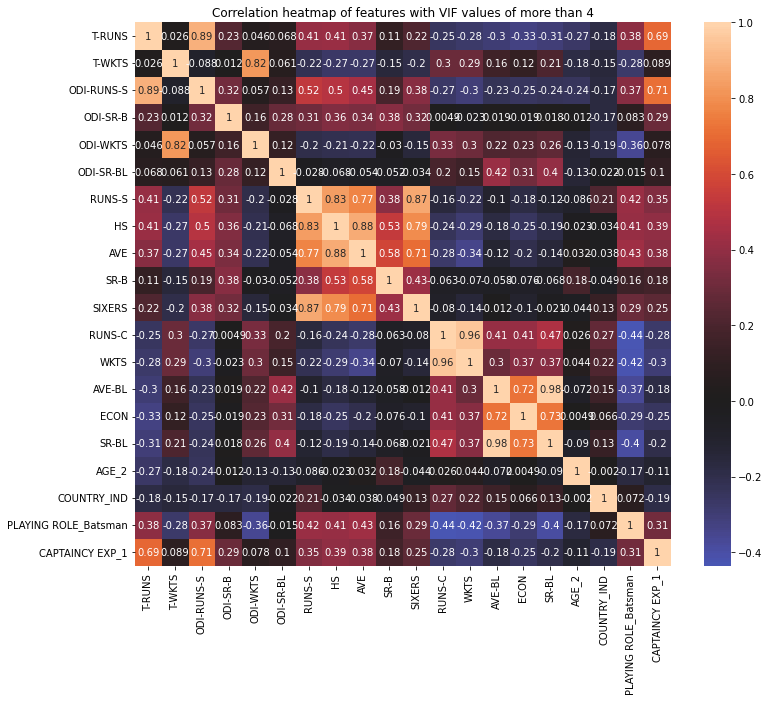

In [66]:
plt.figure(figsize=(12,10))
sns.heatmap(X[large_vif_features].corr(), annot=True, center=0.0)
plt.title("Correlation heatmap of features with VIF values of more than 4")

In [67]:
#From observation, T-RUNS and ODI_RUNS-S, ODI_WKTS and T-WKTS are hghly correlated
#Moreover Batsman features like RUNS-S, HS, AVE, SIXERS are highly correlated, 
#Bowler features such as AVE-BL, ECON and SR-BL are highly correlated
# We can keep one of these highly correlated variables and remove the other

#Over multiple iterations, we decideto remove the following variables -

features_to_be_removed = ['T-RUNS', 'T-WKTS', 'RUNS-S', 'HS', 'AVE', 'RUNS-C', 'SR-B', 'AVE-BL', \
                     'ECON', 'ODI-SR-B', 'ODI-RUNS-S', 'AGE_2', 'SR-BL']

In [68]:
#Lets filter out these unwanted features

X_new_features = list(set(X_features) - set(features_to_be_removed))

get_vif_factors(X[X_new_features])

,column,VIF
0,COUNTRY_SL,1.519752
1,PLAYING ROLE_Bowler,3.060168
2,COUNTRY_IND,3.144668
3,COUNTRY_SA,1.416657
4,COUNTRY_WI,1.194093
5,ODI-SR-BL,2.822148
6,COUNTRY_NZ,1.173418
7,WKTS,2.883101
8,AGE_3,1.779861
9,CAPTAINCY EXP_1,2.458745


In [69]:
#Lets retrain the model with just these uncorrelated features

train_X = train_X[X_new_features]
ipl_model_2 = sm.OLS(train_Y, train_X.astype(float)).fit()
ipl_model_2.summary2()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
========================================================================================
Model:                      OLS                Adj. R-squared (uncentered):   0.728     
Dependent Variable:         SOLD PRICE         AIC:                           2965.1080 
Date:                       2022-05-25 15:47   BIC:                           3012.7070 
No. Observations:           104                Log-Likelihood:                -1464.6   
Df Model:                   18                 F-statistic:                   16.49     
Df Residuals:               86                 Prob (F-statistic):            1.13e-20  
R-squared (uncentered):     0.775              Scale:                         1.2071e+11
----------------------------------------------------------------------------------------
                          Coef.       Std.Err.     t    P>|t|     [0.025       0.975]   
----------------------------------------------------------------------------------------
COUNTRY_SL               55912.3398 142277.1829  0.3930 0.6953 -226925.3388  338750.0184
PLAYING ROLE_Bowler     -18315.4968 106035.9664 -0.1727 0.8633 -229108.0215  192477.0279
COUNTRY_IND             282829.8091  96188.0292  2.9404 0.0042   91614.3356  474045.2827
COUNTRY_SA              108735.9086 115092.9596  0.9448 0.3474 -120061.3227  337533.1399
COUNTRY_WI              -22234.9315 213050.5847 -0.1044 0.9171 -445765.4766  401295.6135
ODI-SR-BL                  909.0021   1267.4969  0.7172 0.4752   -1610.6983    3428.7026
COUNTRY_NZ              142968.8843 151841.7382  0.9416 0.3491 -158882.5009  444820.2695
WKTS                      2431.8988   2105.3524  1.1551 0.2512   -1753.4033    6617.2008
AGE_3                    -8950.6659  98041.9325 -0.0913 0.9275 -203851.5772  185950.2453
CAPTAINCY EXP_1         208376.6957  98128.0284  2.1235 0.0366   13304.6315  403448.7600
PLAYING ROLE_Batsman    121382.0570 106685.0356  1.1378 0.2584  -90700.7746  333464.8886
ODI-WKTS                   772.4088    470.6354  1.6412 0.1044    -163.1834    1708.0009
COUNTRY_ZIM             -67977.6781 390859.9289 -0.1739 0.8623 -844981.5006  709026.1444
COUNTRY_PAK             122810.2480 159600.8063  0.7695 0.4437 -194465.6541  440086.1502
COUNTRY_BAN            -108758.6040 369274.1916 -0.2945 0.7691 -842851.4010  625334.1930
COUNTRY_ENG             682934.7166 216150.8279  3.1595 0.0022  253241.0920 1112628.3411
PLAYING ROLE_W. Keeper  -55121.9240 169922.5271 -0.3244 0.7464 -392916.7280  282672.8801
SIXERS                    7862.1259   2086.6101  3.7679 0.0003    3714.0824   12010.1694
----------------------------------------------------------------------------------------
Omnibus:                       8.635               Durbin-Watson:                  2.252
Prob(Omnibus):                 0.013               Jarque-Bera (JB):               8.345
Skew:                          0.623               Prob(JB):                       0.015
Kurtosis:                      3.609               Condition No.:                  1492 
========================================================================================
* The condition number is large (1e+03). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [70]:
# Lets create a list of features which have p value less than 0.05

significant_vars = ['CAPTAINCY EXP_1', 'COUNTRY_IND', 'COUNTRY_ENG', 'SIXERS']

train_X = train_X[significant_vars]
ipl_model_3 = sm.OLS(train_Y, train_X.astype(float)).fit()
ipl_model_3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.704     
Dependent Variable:     SOLD PRICE       AIC:                         2961.8089 
Date:                   2022-05-25 15:49 BIC:                         2972.3864 
No. Observations:       104              Log-Likelihood:              -1476.9   
Df Model:               4                F-statistic:                 62.77     
Df Residuals:           100              Prob (F-statistic):          1.97e-26  
R-squared (uncentered): 0.715            Scale:                       1.3164e+11
--------------------------------------------------------------------------------
                     Coef.      Std.Err.    t    P>|t|     [0.025      0.975]   
--------------------------------------------------------------------------------
CAPTAINCY EXP_1   359725.2741  74930.3460 4.8008 0.0000 211065.6018  508384.9463
COUNTRY_IND       387890.2538  63007.1511 6.1563 0.0000 262885.8606  512894.6471
COUNTRY_ENG       731833.6386 214164.4988 3.4172 0.0009 306937.3727 1156729.9045
SIXERS              8637.8344   1675.1313 5.1565 0.0000   5314.4216   11961.2472
--------------------------------------------------------------------------------
Omnibus:                   1.130             Durbin-Watson:                2.238
Prob(Omnibus):             0.568             Jarque-Bera (JB):             0.874
Skew:                      0.223             Prob(JB):                     0.646
Kurtosis:                  3.046             Condition No.:                165  
================================================================================

"""

<Figure size 576x432 with 0 Axes>

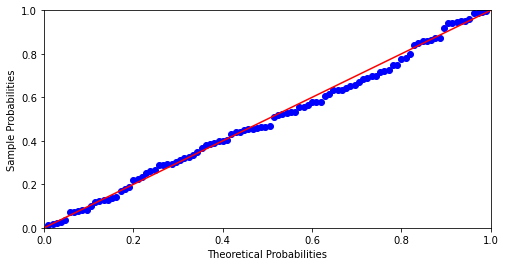

In [72]:
#Lets diagnose the model

#First, lets create a function which shows residual plot

def draw_pp_plot(model, title):
    probplot = sm.ProbPlot(model.resid, fit=True)
    plt.figure(figsize=(8,6))
    probplot.ppplot(line='45')
    plt.show()
    
draw_pp_plot(ipl_model_3, 'Normal P-P Plot of Regression Standardized Residuals')

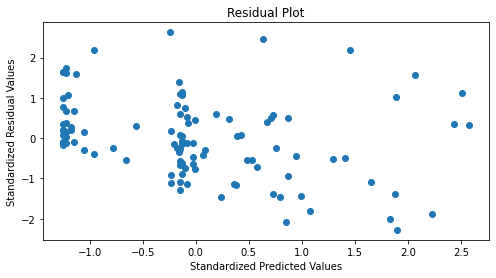

In [74]:
#WE can conclude the CDF of residuals is pretty close to CDF of normal dist. SO assumption is valid
#Now, lets check for homoscedasticity
#We have already defined function to plot residual values above

plot_resid_fitted(ipl_model_3.fittedvalues, ipl_model_3.resid, 'Residual Plot')

In [76]:
# Not in a funnel shape, hence homscedasticity is maintained
# Lets also look for influencers (using leverage values) if any

k = train_X.shape[1]
n = train_X.shape[0]
print("Number of Observations: ",n, "\nNumber of features: ",k)
leverage_cutoff = 3*((k+1)/n)
print("Leverage value cutoff: ", leverage_cutoff)

Number of Observations:  104 
Number of features:  4
Leverage value cutoff:  0.14423076923076925


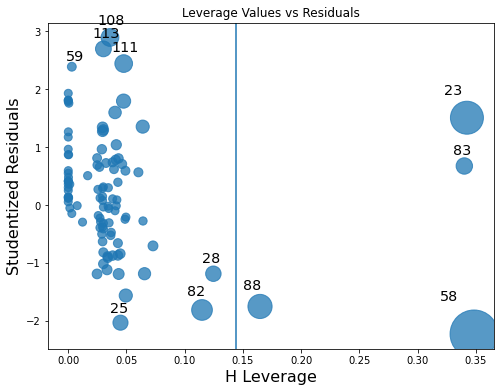

In [80]:
#So observations with leverage values more than 0.144 are highly influential
#Lets plot influence plot and check

from statsmodels.graphics.regressionplots import influence_plot

fig, ax = plt.subplots(figsize=(8,6))
influence_plot(ipl_model_3, ax=ax)
plt.title("Leverage Values vs Residuals")
plt.axvline(x=leverage_cutoff)
plt.show()

In [86]:
#Lets remove the 4 observations (88, 23, 83, 58) that have higher leverage value than cutoff from train test and retrain

train_X_new = train_X.drop([88, 23, 58, 83], axis=0)
train_Y_new = train_Y.drop([88, 23, 58, 83], axis=0)
print(train_X_new.describe())
print(train_Y_new.describe())

       CAPTAINCY EXP_1  COUNTRY_IND  COUNTRY_ENG      SIXERS
count       100.000000   100.000000        100.0  100.000000
mean          0.310000     0.420000          0.0   16.180000
std           0.464823     0.496045          0.0   20.386359
min           0.000000     0.000000          0.0    0.000000
25%           0.000000     0.000000          0.0    1.000000
50%           0.000000     0.000000          0.0    5.000000
75%           1.000000     1.000000          0.0   28.250000
max           1.000000     1.000000          0.0   86.000000
count    1.000000e+02
mean     5.050900e+05
std      3.952938e+05
min      2.000000e+04
25%      2.187500e+05
50%      4.250000e+05
75%      7.000000e+05
max      1.800000e+06
Name: SOLD PRICE, dtype: float64


In [87]:
#Retrain with dropped observations
ipl_model_4 = sm.OLS(train_Y_new, train_X_new.astype(float)).fit()
ipl_model_4.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.696     
Dependent Variable:     SOLD PRICE       AIC:                         2841.5546 
Date:                   2022-05-25 16:19 BIC:                         2849.3701 
No. Observations:       100              Log-Likelihood:              -1417.8   
Df Model:               3                F-statistic:                 77.33     
Df Residuals:           97               Prob (F-statistic):          1.26e-25  
R-squared (uncentered): 0.705            Scale:                       1.2457e+11
--------------------------------------------------------------------------------
                       Coef.     Std.Err.    t    P>|t|     [0.025      0.975]  
--------------------------------------------------------------------------------
CAPTAINCY EXP_1     303734.7027 75592.1328 4.0181 0.0001 153705.2441 453764.1614
COUNTRY_IND         387924.6265 61366.7462 6.3214 0.0000 266128.6225 509720.6304
COUNTRY_ENG              0.0000     0.0000    nan    nan      0.0000      0.0000
SIXERS               10029.1011  1770.0111 5.6661 0.0000   6516.1191  13542.0831
--------------------------------------------------------------------------------
Omnibus:               1.568        Durbin-Watson:           2.205              
Prob(Omnibus):         0.457        Jarque-Bera (JB):        1.115              
Skew:                  0.241        Prob(JB):                0.573              
Kurtosis:              3.185        Condition No.:           8070964340192396288
================================================================================
* The condition number is large (8e+18). This might indicate             strong
multicollinearity or other numerical problems.
"""

Number of Observations:  100 
Number of features:  4
New Leverage value cutoff:  0.15000000000000002


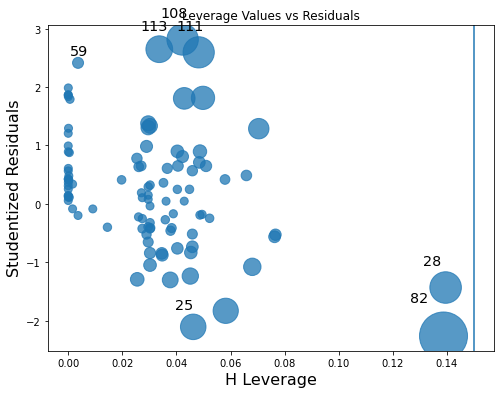

In [89]:
#Lets check Influence plot again

k = train_X_new.shape[1]
n = train_X_new.shape[0]
print("Number of Observations: ",n, "\nNumber of features: ",k)
leverage_cutoff = 3*((k+1)/n)
print("New Leverage value cutoff: ", leverage_cutoff)


fig, ax = plt.subplots(figsize=(8,6))
influence_plot(ipl_model_4, ax=ax)
plt.title("Leverage Values vs Residuals")
plt.axvline(x=leverage_cutoff)
plt.show()

In [90]:
#Sometimes, relationship between output variable might not be linear
#Lets try to train/predict square root value of SOLD PRICE

train_Y_new = np.sqrt(train_Y_new)
ipl_model_5 = sm.OLS(train_Y_new, train_X_new.astype(float)).fit()
ipl_model_5.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.733     
Dependent Variable:     SOLD PRICE       AIC:                         1468.0338 
Date:                   2022-05-25 16:26 BIC:                         1475.8493 
No. Observations:       100              Log-Likelihood:              -731.02   
Df Model:               3                F-statistic:                 92.39     
Df Residuals:           97               Prob (F-statistic):          2.51e-28  
R-squared (uncentered): 0.741            Scale:                       1.3499e+05
-----------------------------------------------------------------------------------
                    Coef.      Std.Err.      t       P>|t|      [0.025      0.975] 
-----------------------------------------------------------------------------------
CAPTAINCY EXP_1    379.6561     78.6890    4.8248    0.0000    223.4802    535.8319
COUNTRY_IND        489.0031     63.8808    7.6549    0.0000    362.2173    615.7888
COUNTRY_ENG          0.0000      0.0000       nan       nan      0.0000      0.0000
SIXERS               9.7297      1.8425    5.2806    0.0000      6.0728     13.3866
--------------------------------------------------------------------------------
Omnibus:              0.068         Durbin-Watson:           1.898              
Prob(Omnibus):        0.966         Jarque-Bera (JB):        0.068              
Skew:                 -0.050        Prob(JB):                0.967              
Kurtosis:             2.922         Condition No.:           8070964340192396288
================================================================================
* The condition number is large (8e+18). This might indicate             strong
multicollinearity or other numerical problems.
"""

<Figure size 576x432 with 0 Axes>

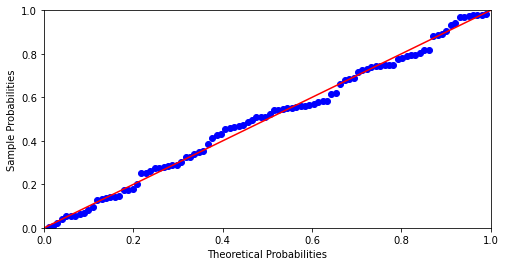

In [91]:
#We can see Adjusted R sq. value increased to 0.733
draw_pp_plot(ipl_model_5, "Normal P-P Plot of Regression Standardized Residuals")

In [92]:
#Yep, residuals follow normal distribution as well

#Lets make predictions
pred_Y = np.power(ipl_model_5.predict(test_X[train_X_new.columns]),2)

In [93]:
from sklearn import metrics
#RMSE -
np.sqrt(mean_squared_error(pred_Y, test_Y))

562643.2045127087

In [94]:
#R Squared Value -
np.round(metrics.r2_score(pred_Y, test_Y), 2)

0.42

In [ ]:
#Accuracy on Validation is quite low (0.42) as compared to Train set (0.733)
#This might be due to overfitting. This will be discussed in another chapter.